**Ethan, Alice, and Cole**

Spring 2020

CS443: Computational Neuroscience

Project 2: Content Addressable Memory

In [291]:
import math
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import preprocessing
from PIL import Image as im


plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])
plt.rcParams.update({'font.size': 20})

np.set_printoptions(suppress=True, precision=3)

# Automatically reload external modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Task 3) Hopfield network

In this task, you will implement and analyze a Hopfield network — a recurrent neural network with content addressable memory. You will use Hebbian learning learn weights that imprint the training data as "memories" that can be recalled with an incomplete and/or distorted version of the training data.

### 3a. Load in image data

- Load in the training set, three color photographs of natural scenes with varying resolution: `train_img_1.png`, `train_img_2.png`, and `train_img_3.png`.
    - *Note that the docstrings/test code in the next tasks assumes that you load in the images as PIL Image objects. You may deviate from this if you prefer a different way to handle this, but note that your binarized feature vectors should look reasonable at the end of Task 3c and be consistent with the shape/type/value test code there.*

In [292]:
img1 = im.open("data/train_img_1.png")
img2 = im.open("data/train_img_2.png")
img3 = im.open("data/train_img_3.png")

### 3b. Consistently resize images

Right now, your images have different spatial resolutions. You should resize them so that they are 128x128 grayscale images.

- In `preprocessing.py`, implement `resize_imgs`.
- Resize the training images below to make them consistently sized and grayscale so that they can be placed in a single ndarray (`shape=(3, 128, 128)`).
- Write code inside `row_plot` below then create a 1x3 row showing all the images side-by-side.

In [293]:
imgs = preprocessing.resize_imgs([img1, img2, img3], 64, 64)
print(imgs.shape)

(3, 64, 64)


In [294]:
def row_plot(imgs, title, cmap='bone', sz=(12, 4)):
    '''Plots images in `imgs` in a single row
        
    Parameters:
    -----------
    imgs: ndarray. shape=(N, Iy, Ix)
        Images to display in the row.
    title: str. Title for entire figure.
    cmap: str. Matplotlib color scale to use when plotting.
        Some good options are "bone" for binary and "grayscale" for grayscale images.
    sz: tuple. Format=(fig_width, fig_height). Size of the entire plot figure.
    
    TODO:
    - Generate the row of images, making sure you set the figure size and color scheme.
    - Label each image with its index in `imgs` (e.g. 0, 1, 2)
    '''
    
    fig = plt.figure(figsize= sz)
    fig.suptitle(title)
    N = imgs.shape[0]
    for i in range(N):
        a = fig.add_subplot(1, N, i+1)
        imgplot = plt.imshow(imgs[i], cmap = cmap)
        a.set_title('Index: ' + str(i))

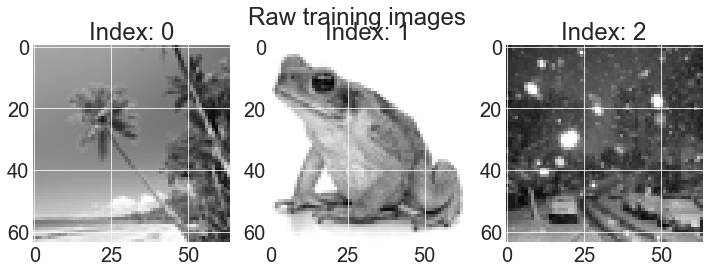

In [295]:
row_plot(imgs, 'Raw training images', cmap='gray')

### 3c. Preprocess images into bipolar feature vectors

Hopfield networks assume that inputs are 1D feature vectors of binary values. In this subtask, you will do the preprocessing to get the images encoded as binary feature vectors. While this can be done by representing values as `[0, 1]`, it is more common to use **bipolar vectors** with either [-1, +1] components. *One extension idea is to investigate why bipolar vectors are preferred over ordinary 0/1 binary.*

For example, before training a Hopfield network, you might flatten and binarize an image, then encode its pixel values as `[-1, +1, -1, -1, -1,...]`.

In `preprocessing.py`, implement the following functions:
- `img2binaryvectors`: Converts grayscale images into bipolar feature vectors.
- `vec2img`: Inflates a binary feature vector back into its (width, height) dimensions so that it can be plotted/visualized.
- In the cell below, show your preprocessed binary images in a row.

In [296]:
# Preprocess here
imgs_pp = preprocessing.img2binaryvectors(imgs) 
print(f'After preprocessing, image data shape: {imgs_pp.shape}, dtype: {imgs_pp.dtype}, Unique values: {np.unique(imgs_pp)}')
print('You should see:\nAfter preprocessing, image data shape: (3, 16384), dtype: int64, Unique values: [-1  1]')

After preprocessing, image data shape: (3, 4096), dtype: int64, Unique values: [-1  1]
You should see:
After preprocessing, image data shape: (3, 16384), dtype: int64, Unique values: [-1  1]


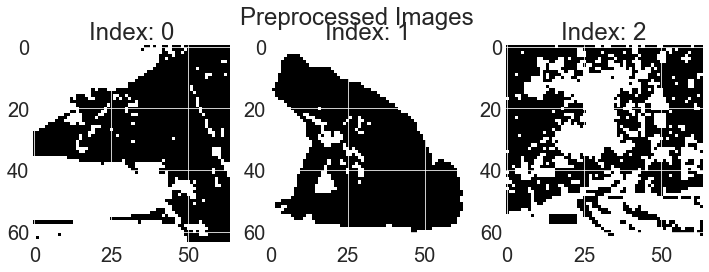

In [297]:
# Plot here
imgs = preprocessing.vec2img(imgs_pp,64, 64)
row_plot(imgs, 'Preprocessed Images', cmap='gray')

### 3d. Implement and train your Hopfield net. Use it to recall training images.

Implement the following methods in `hopfield.py`. Note that there is test code below.
- Constructor: Initializes things, including the weights via `initialize_wts`.
- `initialize_wts`: Use Hebbian learning to generate each neuron's connectivity weights based on all the training data. The Hebbian weight equation is: $$w_{n,m} = \sum_{i=1}^N \vec{I}_{i}^T \vec{I}_{i}$$ where $i$ indexes the $i^{th}$ 1D input feature vector $I$. This equation holds if $i \neq j$. If $i = j$, then $w_{n,m} = 0$ (along main diagonal).
- `energy`: Compute the energy of the current state of the network: $$E = -\frac{1}{2} \sum_{n} \sum_{m} y_n w_{n,m} y_m$$ where $\vec{y}$ is the 1D `net_act` at each index $n$ and $m$ and $w_{n,m}$ is the weight between the corresponding neurons.
- `predict`: Use test images to have the network generate (recall) the 'closest' image in memory (from training set). In this subtask, the test set is the training set (i.e. prompt recall of a memory with the memory). Activation of neurons is done **asychronously** — the `net_act` of only a random subset of neurons are updated at each time step. Equation for updating the `net_act` at each time step $t$:
$$y_{i}(t) = \text{sgn} \left ( \sum_{j=1}^M w_{ij}y_j \right )$$
Above, $\text{sgn} (x)$ is the sign function (+1 if $x > 0$, 0 if $x = 0$, -1 if $x < 0$), $i$ are all indices in the list `inds` of randomly selected neurons to update on timestep $t$.

In [298]:
from hopfield import HopfieldNet

#### Test constructor and `initialize_wts`

In the cell below:
- Create a Hopfield net and train it on the N=3 training images.
- Check your weights with the test code below.

##### (i) Random pattern test

In [299]:
np.random.seed(0)
test_rand_n, test_rand_m = 3, 4
rand_data = np.random.random(size=(test_rand_n, test_rand_m))
rand_net = HopfieldNet(rand_data, orig_width=2, orig_height=2)
print(f'Your weights are:\n{rand_net.wts} and should be:')
print('[[0.    0.345 0.426 0.396]\n [0.345 0.    0.339 0.389]\n [0.426 0.339 0.    0.379]\n [0.396 0.389 0.379 0.   ]]')

Your weights are:
[[0.    0.345 0.426 0.396]
 [0.345 0.    0.339 0.389]
 [0.426 0.339 0.    0.379]
 [0.396 0.389 0.379 0.   ]] and should be:
[[0.    0.345 0.426 0.396]
 [0.345 0.    0.339 0.389]
 [0.426 0.339 0.    0.379]
 [0.396 0.389 0.379 0.   ]]


In [300]:
#for smaller images, only for use on Ethan's computer. 
#to run normally, make sure that (ii) Image pattern test has orig_width and orig_height set to 128
#this cell can run, as the following cell overrides it

imgs = imgs[:, :64, :64]
imgs_pp = preprocessing.img2binaryvectors(imgs)
print(np.unique(imgs_pp, return_counts=True))

(array([-1,  1], dtype=int64), array([6259, 6029]))


In [301]:
imgs = preprocessing.resize_imgs([img1, img2, img3], 64, 64)
imgs_pp = preprocessing.img2binaryvectors(imgs)
imgs_ppxy = preprocessing.vec2img(imgs_pp, 64, 64)

##### (ii) Image pattern test

In [302]:
# make your Hopfield net here
net = HopfieldNet(imgs_pp, 64, 64)
print(f'Your wts have shape {net.wts.shape}. Should be (16384, 16384)')
print(f'Your wts have these min/max values {net.wts.min()}/{net.wts.max()}. Should be -1.0/1.0.\n')
print(f'Is your wt matrix symmetric? {np.allclose(net.wts, net.wts.T)}')

Your wts have shape (4096, 4096). Should be (16384, 16384)
Your wts have these min/max values -1.0/1.0. Should be -1.0/1.0.

Is your wt matrix symmetric? True


#### Test `energy`

NOTE: `imgs_pp` represents the preprocessed bipolar vectors. Substitute your own variable name.

In [303]:
np.random.seed(1)
test_net = HopfieldNet(imgs_pp, 64, 64)
test_M = 100
test_net_act = np.random.choice([-1, 1], size=test_M)
test_net.wts = np.random.choice([-1, 1], size=(test_M, test_M))
print(f'The network energy with the test random pattern is {test_net.energy(test_net_act):.2f} and should be -14.00.')

The network energy with the test random pattern is -14.00 and should be -14.00.


#### Test `predict`: Recall trained image

In [304]:
preds = net.predict(imgs_pp, update_frac=0.1, verbose=False, show_dynamics=False)

### 3e. Accuracy of memory

Now that you have your recalled memories, check to see how faithfully they represent the training data.

- In `preprocessing.py`, implement the `recall_error` function to measure how different the network's recalled memory is from the corresponding trained image. 

In [305]:
print(f'Recovered image error rates: {preprocessing.recall_error(imgs_pp[np.arange(len(imgs_pp))], preds)}')

Recovered image error rates: 0.0


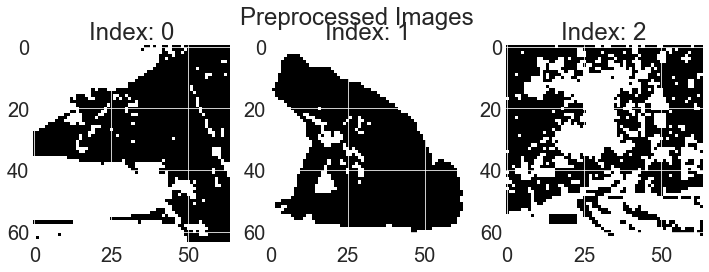

In [306]:
pred_imgs = preprocessing.vec2img(preds,64, 64)
row_plot(pred_imgs, 'Preprocessed Images', cmap='gray')

**Question 1:** How accurately does the Hopfield network recall the N=3 images when training set = test set?

**Answer 1:** When training set = test set, the net recalls the 3 images perfectly. Additionally, it only takes two net act updates for this to happen. 

### 3f. Plot recalled memories

- Fill in the function `plot_data_and_recalled` that will plot each original image and recalled memory side-by-side in the same row.
- In the cell below, call the function on your test case when train = test. 

In [307]:
def plot_data_and_recalled(data, recalled, maxRows=5, cmap='bone', sz=(4, 10)):
    '''Plot a grid of images where corresponding `data` and `recalled` images are in
    the same row side-by-side.
    
    Parameters:
    -----------
    data: ndarray. shape=(N, Iy, Ix)
        Original images used to train network
    recalled: ndarray. shape=(N, Iy, Ix)
        Recalled images generatedd from the train network
    maxRows: int. Limit the number of rows to this number.
    cmap: str. Matplotlib color scale to use when plotting.
        Some good options are "bone" for binary and "grayscale" for grayscale images.
    sz: tuple. Format=(fig_width, fig_height). Size of the entire plot figure.
    
    TODO:
    - Generate the row of images, making sure you set the color scheme.
    - Label the columns "data" and "recalled"
    '''
    fig = plt.figure(figsize= sz)
    
    N = data.shape[0]
    
    for i in range(N):
        a = fig.add_subplot(N, 2, 2*i+1)
        imgplot = plt.imshow(data[i], cmap = cmap)
        a.set_title('data')
        
        a = fig.add_subplot(N, 2, 2*i+2)
        imgplot = plt.imshow(recalled[i], cmap = cmap)
        a.set_title('recalled')

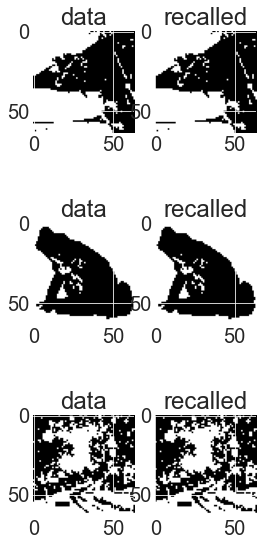

In [308]:
# Plot training images next to recalled images when train == test
plot_data_and_recalled(imgs_ppxy, pred_imgs, maxRows=5, cmap='gray', sz=(4, 10))

### 3g. Noisy data

Below, write code that mirrors what you did with Fuzzy ART:

- Train the network on the same images but prompt the network to recall memories when you insert 10% random noise to each test image (10% of binary values are flipped in each image). 
- Plot the TEST (noisy) and recalled images side-by-side.

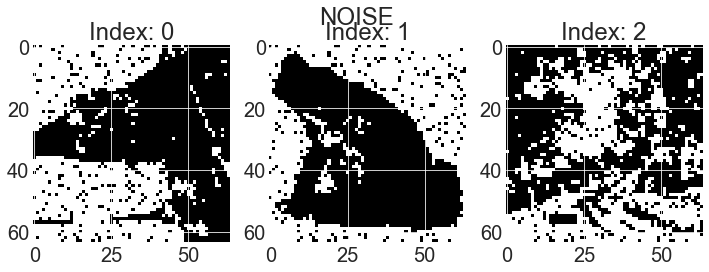

In [309]:
imgs_noise = preprocessing.resize_imgs([img1, img2, img3], 64, 64)
imgs_pp_noise = preprocessing.img2binaryvectors(imgs_noise)
inds = np.random.choice(np.arange(imgs_pp.shape[1]), size=int(imgs_pp.shape[1]/10))
noisy = np.copy(imgs_pp_noise)
noisy[:, inds] = np.where(imgs_pp_noise[:, inds] == 0, 1., -1)
imgs_pp_noisexy = preprocessing.vec2img(noisy, 64, 64)
row_plot(imgs_pp_noisexy, 'NOISE')

In [310]:
preds_noise = net.predict(noisy, update_frac=0.1, verbose=True, show_dynamics=False)

iterations 23
iterations 25
iterations 15


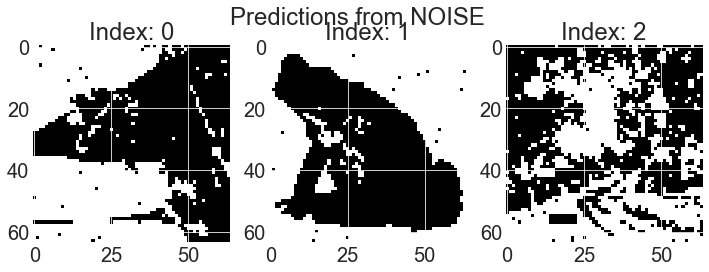

In [311]:
pred_imgs_noise = preprocessing.vec2img(preds_noise, 64, 64)
row_plot(pred_imgs_noise, 'Predictions from NOISE', cmap='gray')

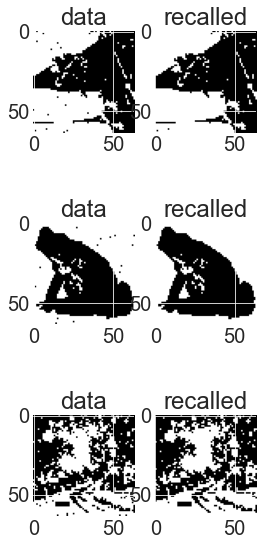

In [312]:
pred_imgs_noise = preprocessing.vec2img(preds, 64, 64)
plot_data_and_recalled(imgs_pp_noisexy, pred_imgs_noise, maxRows=5, cmap='gray', sz=(4, 10))

**Question 2:** How accurately does the Hopfield network recall the N=3 images when the test images are noisy?

**Question 3:** In your own words, describe how the network is doing this.

**Answer 2:** The network does a pretty good job of recalling the 3 images when there is noise in the images.Maybe 5% of the noise remains in the image after doing the predictions.

**Answer 3:** The energy of the network must decrease on every time step, so the network is essentially finding a minimum energy value. In the energy landscape, each local minimum is a training sample. So when energy converges to a local minimum, it is extremely close to a learned memory, meaning that the net act values are very close to the values of the learned memory. 
The reduction in energy is visualized by the noisy pixels turning into the pixels that they should be, i.e. getting closer to the local minimum of the learned memory.


### 3h. Missing data

Below, write code that mirrors what you did with Fuzzy ART:

- Train the network on the same images but prompt the network to recall memories where half of the pixels are set to -1 (if plotted, the bottom half of each image). 
- Plot the TEST (with half data missing) and recalled images side-by-side.

-6594
-6594


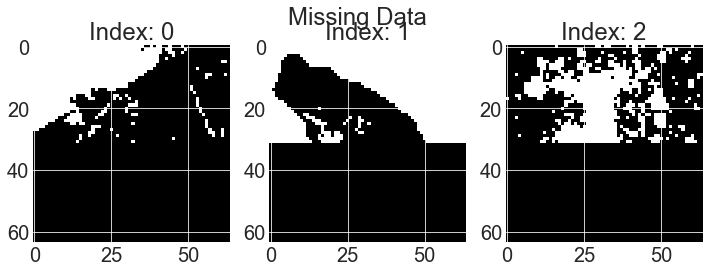

In [354]:
imgs = preprocessing.resize_imgs([img1, img2, img3], 64, 64)
imgs_pp = preprocessing.img2binaryvectors(imgs)
net = HopfieldNet(imgs_pp, 64, 64)

miss = np.copy(imgs_pp)
miss[:, 64*32:] = -1
print(np.sum(miss))
row_plot(preprocessing.vec2img(miss, 64, 64), 'Missing Data')
print(np.sum(miss))

In [357]:
preds = net.predict(miss, update_frac=0.1, verbose=False, show_dynamics=False)
print(np.sum(miss))

-326


-334


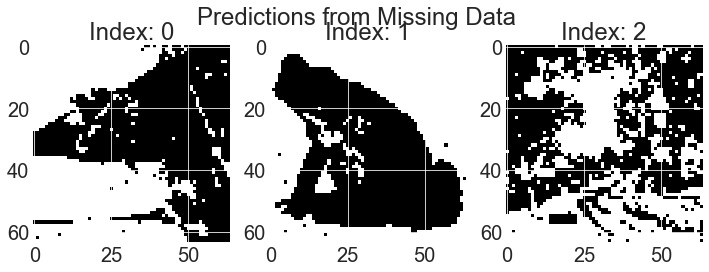

In [347]:
pred_miss = preprocessing.vec2img(preds,64, 64)
row_plot(pred_miss, 'Predictions from Missing Data', cmap='gray')
print(np.sum(miss))

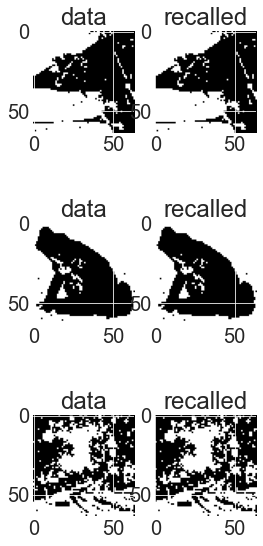

In [348]:
plot_data_and_recalled(preprocessing.vec2img(miss, 64, 64), pred_miss, maxRows=5, cmap='gray', sz=(4, 10))
# print(np.allclose(miss, pred_miss))

**Question 4:** How accurately does the Hopfield network recall the N=3 images when the test images have missing information?

**Question 5:** In your own words, describe how the network is doing this.

**Answer 4:** When the test images have missing information, the net recalls the 3 images very well. There are only a few stray pixels in the first two images, and it’s tough to tell if there are any in the third image.

**Answer 5:** The network is minimizing its energy, and in doing so it is converging to a local minimum. The process is essentially the same as it is when the data are noisy, the only difference is that the noise is all bunched together in this case. 

## Task 4) Hopfield network storage capacity

In this task, you will explore the storage properties of Hopfield networks.

### 4a. Digits dataset

- In the cell below, load in the digits dataset (`digits.txt`). There are 10 digits in total (N=10), each occupies 7 rows and 9 columns of the text file. The digits are represented as 1s and the background pixels are 0s. Ultimately, format the data in bipolar format in two ndarrays: one for visualization (`shape=(10, 7, 9)`) and the other for training the data (`shape=(10, 63)`).
- Make a row plot showing the preprocessed data. 

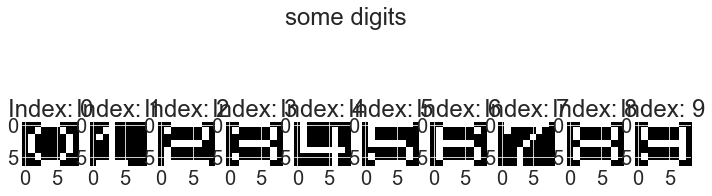

In [317]:
n_digits = 10
n_rows  = 7
n_cols = 9

# Import, preprocess, and plot digits ultimately as ndarrays
text = np.loadtxt('data/digits.txt', dtype=np.str)
digits = np.zeros((10, 7, 9))

for i in range(digits.shape[0]):
    for j in range(digits.shape[1]):
        for k in range(digits.shape[2]):
            digits[i, j, k] = text[i*7+j][k]
digits = np.where(digits == 0, -1, 1)
training_data = np.reshape(digits, (digits.shape[0], -1))
row_plot(digits, 'some digits')

### 4b. Capacity experiments

- Create the test set: noisy versions of the digits (10% noise should be fine).
- Train a Hopfield network multiple times, starting with only one digit (e.g. 0). Test on the noisy version of the same digit. Then train/test on 2 digits, etc. You are looking for a qualitative change in the accuracy/ouputs of the Hopfield network. Before you're sure that you've found it, try increasing `update_frac` to see if that helps.
- Below, create two`plot_data_and_recalled` plots: before and after the critical change.

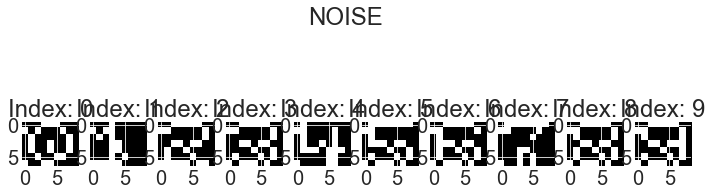

In [318]:
test_data = np.copy(training_data)


inds = np.random.choice(np.arange(test_data.shape[1]), size=int(test_data.shape[1]/10))

noisy_test = np.copy(test_data)
noisy_test[:, inds] = np.where(test_data[:, inds] == -1, 1., -1)
noisy_test_xy = preprocessing.vec2img(noisy_test, 7, 9)
row_plot(noisy_test_xy, 'NOISE')

In [319]:
all_preds = []
for i in range(10):
    net = HopfieldNet(training_data[:i+1], 7, 9)
    all_preds.append(net.predict(test_data[:i+1], update_frac=0.6))
    
    

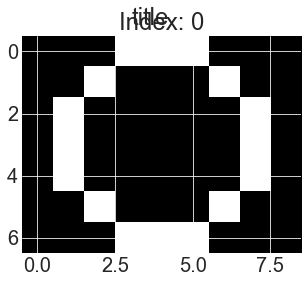

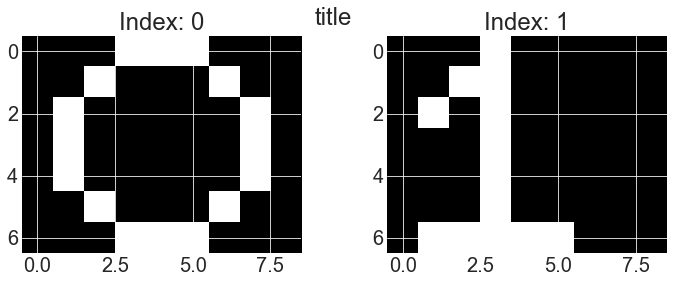

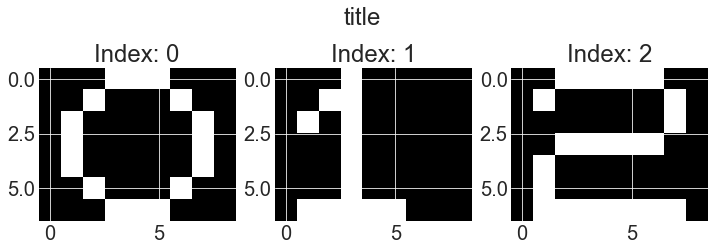

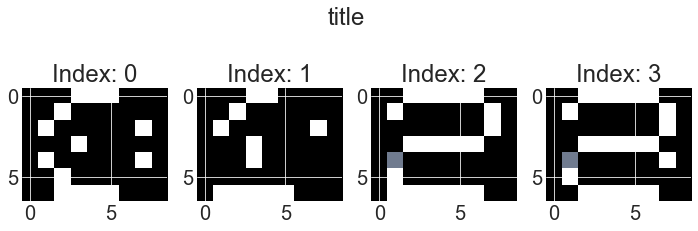

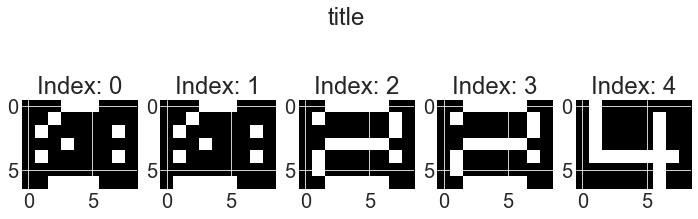

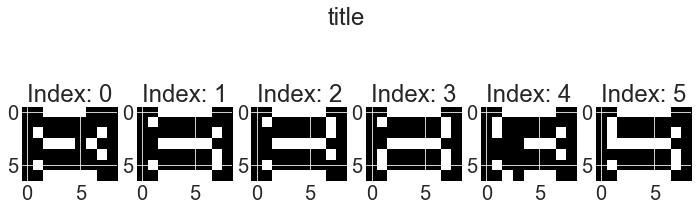

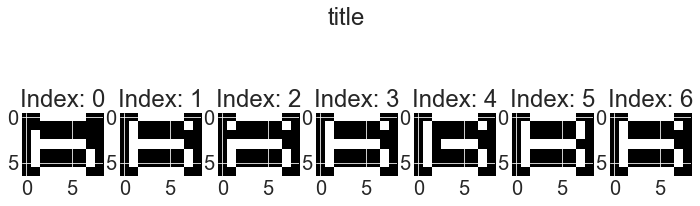

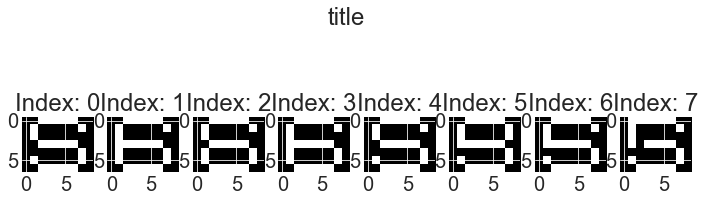

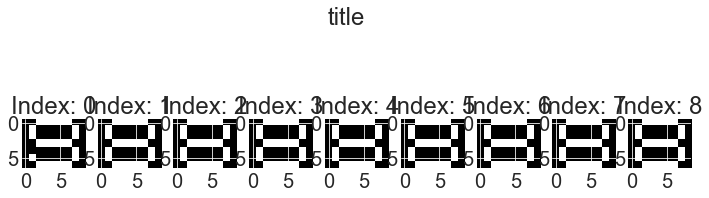

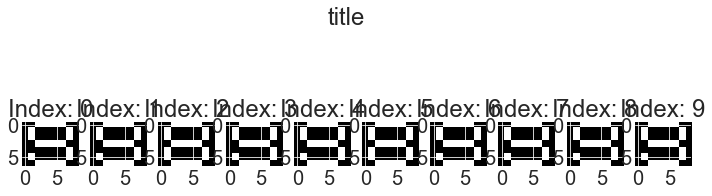

In [320]:
for i in range(len(all_preds)):
    row_plot(preprocessing.vec2img(all_preds[i], 7, 9), 'title')

(3, 63)


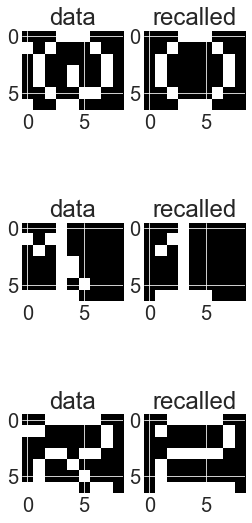

In [321]:
print(test_data[:3].shape)
plot_data_and_recalled(preprocessing.vec2img(noisy_test_xy[:3], 7, 9), preprocessing.vec2img(all_preds[2], 7, 9))
# def plot_data_and_recalled(data, recalled, maxRows=5, cmap='bone', sz=(4, 10)):

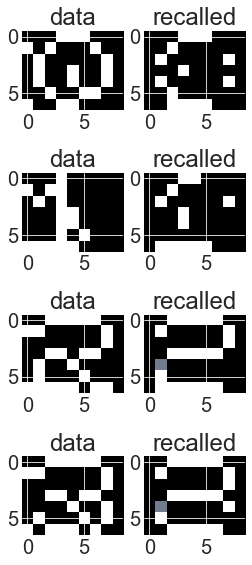

In [322]:
plot_data_and_recalled(preprocessing.vec2img(noisy_test_xy[:4], 7, 9), preprocessing.vec2img(all_preds[3], 7, 9))


**Question 6:** Describe what happens before and after the critical change. 

**Question 7:** At what training size did the critical change happen?

**Question 8:** Decribe what is happening with respect to the data and memory storage of the network and why. Be detailed in your answer. *Hint: Think about the weights and the differences in inputs within this dataset.*

**Answer 6:** Before the critical change, we can tell all of the digits apart. Afterwards, we cannot tell them apart. All of the predictions look the same as each other.

**Answer 7:** It looks like it was either with N=4 or N=5 with an update_frac of 0.5. At N=4, 0 and 1 had the same prediction, and at N=5, none of the predictions were correct and they all looked similar. 

**Answer 8:** The weights matrix is only MxM, which is 63x63 in this case. There are a always a finite number of possible minima that can exist given a limited number of weights, and we found that there are only about 3 in this case. If we had larger images, we may be able to have more local minima in our energy space, so we might be able to store more images. 

## Extensions

Extension 1 is in FuzzyArt.mlx at the bottom

### 1) Binary vs. bipolar feature representations

### 2) Run experiments on any of the CAM networks with your own images to address a hypothesis that you have

- Don't just run another image dataset through the models. Have a hypothesis in mind (please state it) and run tests and analyze the results informed by this hypothesis (did you support or invalidate it?). 

### 3) Non-image data

- CAM models work on lots of different types of data, not just images. For example, you could train the models on DNA nucleotide sequences (e.g. strings of ACGT). To do this, you could encode DNA sequences as concatenated length 4 one-hot vectors (there are only 4 possible base pairs), then run experiments like checking to see if the trained network can detect the closest sequence to a test sequence with a mutation (1+ letters ommitted/subsituted/etc).

### 4) Implement and compare with other CAM networks

- There are other networks with similar architectures as Hopfield networks, such as brain-state-in-a-box (and generalized brain-state-in-a-box) and bidirectional associative memory (*there is a dynamic network version, different from the matrix based algorithm covered in class*). Research a network, report on its differences, implement it, test out / compare capcity, CAM recall, etc.
    - Boltzmann machines (and restricted boltzmann machines) are in this category, though they probably are too large of an undertaking for an extension!

### 5) Maximizing storage capacity

- Even visually simple bipolar images actually have a high degree of feature redundancy that makes memory storage more challenging for Hopfield networks. Train and test recall on orthogonal and nearly-orthogonal feature vectors (i.e. those with controlled levels of "noise" or "corruption"). How many patterns can you accurately store?